In [5]:
import tensorflow as tf
print(tf.__version__)
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD

# !pip install -q tensorflow-datasets


2.3.0


In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


In [3]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [6]:
stopwords = pd.read_csv('stopwords.txt', header=None)
stopwords = stopwords.loc[:, 0].to_numpy()

In [11]:
tf_idf = TfidfVectorizer(stop_words={'english'})

train_sequences = tf_idf.fit_transform(training_sentences)
test_sequences = tf_idf.fit_transform(testing_sentences)

In [15]:
svd = TruncatedSVD(n_components=64)
padded_train = svd.fit_transform(train_sequences.toarray())
padded_test = svd.fit_transform(test_sequences.toarray())

KeyboardInterrupt: 

In [14]:
train_sequences

<25000x74848 sparse matrix of type '<class 'numpy.float64'>'
	with 3445072 stored elements in Compressed Sparse Row format>

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, SimpleRNN, GRU, Bidirectional, GlobalAveragePooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [43]:
callbacks = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3)

In [68]:
model = Sequential()
# model.add(Embedding(input_dim=num_words, output_dim=64, input_length=maxlen))
# model.add(GRU(32, activation='relu', return_sequences=True))
model.add()
# model.add(Bidirectional(LSTM(16, activation='relu')))
model.add(SimpleRNN(32, activation='relu', input_dim=padded_train.shape[1]))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], )
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 120, 64)           640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                10368     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 650,401
Trainable params: 650,401
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit(x=padded_train, y=training_labels_final, batch_size=32, epochs=20, 
          validation_data=(padded_test, testing_labels_final), callbacks=[callbacks])

Epoch 1/20
131/782 [====>.........................] - ETA: 48s - loss: 3.4106 - accuracy: 0.5501

KeyboardInterrupt: 

In [54]:
import matplotlib.pyplot as plt

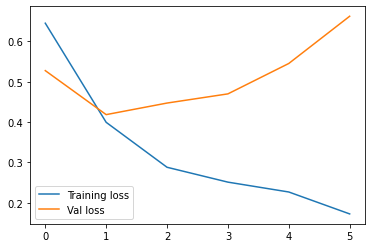

In [64]:
plt.plot(history.history.get('loss'), label='Training loss')
plt.plot(history.history.get('val_loss'), label='Val loss')
plt.legend(loc='best')
plt.show()

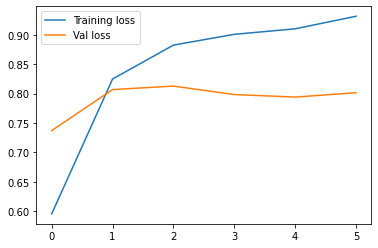

In [65]:
plt.plot(history.history.get('accuracy'), label='Training loss')
plt.plot(history.history.get('val_accuracy'), label='Val loss')
plt.legend(loc='best')
plt.show()

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


In [ ]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [ ]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)